# Analysis of Major League Baseball (MLB) Statistics with Supervised Learning Models

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
plt.rcParams['figure.figsize'] = (30,30)

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df

,Unnamed: 0,matchID,date,day_of_week,name,league,game_number,score,length_outs,day_night,park_id,attendance,length_minutes,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional walks,...,errors,passed_balls,double_plays,triple_plays,hp_umpire_id,1b_umpire_id,2b_umpire_id,3b_umpire_id,manager_id,winning_pitcher_id,losing_pitcher_id,saving_pitcher_id,winning_rbi_batter_id,starting_pitcher_id,player_1_id,player_2_id,player_3_id,player_4_id,player_5_id,player_6_id,player_7_id,player_8_id,player_9_id,winning_team,winner
0,0,0,19460416,Tue,DET,AL,1,2,51,D,DET04,52900.0,110.0,01010000x,28.0,6.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.0,1.0,0.0,mcgob901,rue-j901,NaN,passa901,oneis101,newhh101,pottn102,NaN,greeh102,newhh101,lakee101,mayoe101,mccob101,greeh102,waked101,mullp101,higgm101,richp101,newhh101,Home,1.0
1,10,10,19460417,Wed,PHA,AL,2,7,51,D,PHI11,11901.0,120.0,10000051x,31.0,9.0,2.0,1.0,0.0,6.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,0.0,boyej901,joner901,NaN,romme101,mackc101,newsb101,gumpr101,NaN,kellg102,newsb101,garrf101,peckh101,wallj102,chaps101,mcqug101,rosab101,kellg102,handg101,newsb101,Home,1.0
2,16,16,19460418,Thu,DET,AL,3,6,51,D,DET04,16469.0,118.0,10030011x,36.0,12.0,3.0,1.0,0.0,6.0,0.0,0.0,0.0,6.0,1.0,...,0.0,0.0,0.0,0.0,passa901,mcgob901,NaN,rue-j901,oneis101,benta101,galed101,NaN,greeh102,benta101,lakee101,mayoe101,mccob101,greeh102,waked101,mullp101,higgm101,richp101,benta101,Home,1.0
3,19,19,19460418,Thu,BRO,NL,3,8,51,D,NYC15,31825.0,136.0,00512000x,32.0,9.0,1.0,2.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,...,1.0,0.0,1.0,0.0,dunnt901,henlb101,mageg901,stewb901,durol101,lombv101,feldh101,NaN,whitd103,lombv101,whitd103,hermb101,reisp101,steve101,hermg101,furic101,andef102,reesp101,lombv101,Home,1.0
4,23,23,19460420,Sat,BOS,AL,4,2,51,D,BOS07,30446.0,94.0,10000001x,24.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,6.0,0.0,...,0.0,0.0,1.0,0.0,romme101,boyej901,NaN,joner901,cronj101,hught102,fowld101,NaN,peskj101,hught102,dimad101,peskj101,willt103,doerb101,yorkr101,metkg101,andre103,wagnh102,hught102,Home,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167739,83866,94926,20161002,Sun,CIN,NL,162,4,54,D,CIN09,32587.0,198.0,300100000,32.0,6.0,2.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,1.0,0.0,whitc901,belld901,morag901,hallt901,pricb801,grimj002,igler001,edwac001,szczm001,stepr002,peraj003,dejei002,vottj001,duvaa001,sches001,suare001,barnt001,rendt001,stepr002,Visitor,0.0
167740,83867,94927,20161002,Sun,COL,NL,162,4,60,D,DEN02,27762.0,203.0,1100100010,41.0,13.0,4.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,barrs901,woodt901,randt901,ortir901,weisw001,thort001,rusic001,knebc001,susaa001,marqg001,blacc001,dahld001,arenn001,gonzc001,murpt002,pattj005,valap001,adamc001,marqg001,Visitor,0.0
167741,83868,94928,20161002,Sun,PHI,NL,162,5,51,D,PHI13,36935.0,159.0,00100031x,33.0,10.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,barkl901,herna901,barrt901,littw901,mackp101,murrc002,goede001,nerih001,hernc005,eickj001,hernc005,parej002,herro001,franm004,howar001,ruppc001,blana001,altha001,eickj001,Visitor,0.0
167742,83870,94930,20161002,Sun,SLN,NL,162,10,51,D,STL10,44615.0,192.0,00100360x,36.0,12.0,2.0,0.0,1.0,10.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,1.0,0.0,cuzzp901,ticht901,vanol901,marqa901,mathm001,broxj001,nicaj001,NaN,piscs001,waina001,carpm002,diaza003,moliy001,piscs001,peraj001,mossb001,gyorj001,gricr001,waina001,Visitor,0.0


In [4]:
for column in df.columns:
    if '_id' in column:
        df.drop(columns=column, inplace=True)

# Feature selection

Look at the vif and run a decision tree to find the feature importance to help select those. The columns we are dropping at this stage have been selected because the information they provide doesn't help our business case.

In [5]:
y = df['winner']
X = df.drop(columns=['Unnamed: 0', 'matchID', 'winner', 'league', 'score', 'winning_team', 'line_score', 'name', 'day_night'])

## Correlation matrix

In [6]:
# sns.heatmap(X.corr(), center=0, annot=True);

## Variance Inflation Factor

In [6]:
# Preparing the data for the VIF analysis
day = X['day_of_week'].str.get_dummies()
X = X.join(day)
X.drop(columns=['day_of_week'], inplace=True)

In [8]:
# Xvif = X.loc[:, :'triple_plays']

In [9]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]
# list(zip(Xvif.columns, vif))

In light of this analysis, let's redefine our X and y:

In [7]:
y = df['winner']
# Columns dropped after VIF analysis:
X.drop(columns=['length_outs', 'at_bats', 'putouts'], inplace=True)

## Decision Tree to identify important features

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
                                                   )

X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                           y_train,
                                                           test_size=0.3,
                                                           random_state=42
                                                           )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

In [9]:
# Train Decision tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

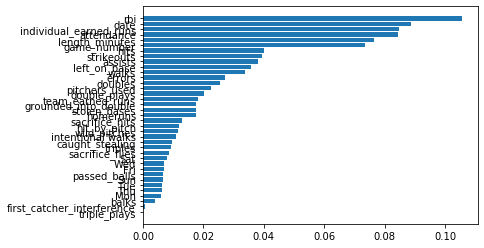

In [10]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)),importances[indices], align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);

Now that we understand a bit more what kind of information we are dealing with, let's see if a model can help us predict the outcome of a game:

# Baseline model: logistic regression

In [11]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_validate_s = scaler.transform(X_validate)

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_s, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### ROC_AUC of the folds

In [12]:
cross_val_score(logreg, X_train_s, y_train, scoring='roc_auc', cv=kfold)

array([0.60958901, 0.60746608, 0.61641603, 0.60943864, 0.61632727])

### AUC score of train vs validate

In [13]:
y_score = logreg.fit(X_train_s, y_train).decision_function(X_validate_s)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.6150123204318018


_Note: We are using the AUC score to be able to compare all our models and select the most performant one._

# Decision Tree

Using GridSearchCV to find the bext parameters for our Decision Tree model:

In [17]:
# Initial hyperparameter ranges
# param_grid = {'criterion' : ['gini','entropy'],
#               'max_depth' : [x for x in range(2,10)],
#               'min_samples_leaf' : [x for x in range(500,5000,500)]
#              }

# Output
# criterion: entropy
# max_depth: 9
# min_samples_leaf: 500
# accuracy: 0.64583

# Second round
# param_grid = {'criterion' : ['gini','entropy'],
#               'max_depth' : [x for x in range(7,20)],
#               'min_samples_leaf' : [x for x in range(100,1000,100)]
#              }

# Output
# criterion: gini
# max_depth: 1
# min_samples_leaf: 400
# ROC_AUC: 0.72065

param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(7,20)],
              'min_samples_leaf' : [x for x in range(100,500,100)]
             }
dtree = DecisionTreeClassifier()

In [18]:
# grid = GridSearchCV(estimator = dtree, 
#                     param_grid = param_grid, 
#                     scoring = 'roc_auc',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

In [19]:
# grid = grid.fit(X_train, y_train)
# criterion = grid.best_params_['criterion']
# max_depth = grid.best_params_['max_depth']
# min_samples_leaf = grid.best_params_['min_samples_leaf']
# print(f'criterion: {criterion}')
# print(f'max_depth: {round(max_depth,5)}')
# print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
# print(f'ROC_AUC: {round(grid.best_score_,5)}')

# Output
# criterion: entropy
# max_depth: 13
# min_samples_leaf: 400
# ROC_AUC: 0.72172

In [20]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=400)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=400, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### ROC_AUC of the 'optimal' decision tree

In [21]:
y_score = clf.predict_proba(X_validate)
fpr, tpr, thresholds = roc_curve(y_validate, [y_score[x][1] for x in range(len(y_score))])
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7208263973149066


_Note: That is more than 10% over the initial model, not bad!_

### Graphical representation of the 'optimal' decision tree

In [22]:
# Graphical representation of the decision tree

export_graphviz(clf,
                out_file='tree.dot', 
                feature_names=X_train.columns,  
                class_names=np.unique(y).astype('str'), 
                filled=True,
                rounded=True,
                special_characters=True,
                precision = 2
                )

In [23]:
from subprocess import Popen, PIPE
Popen('dot -Tpng tree.dot -o tree.png -Gdpi=600', shell=True, stdout=PIPE, stderr=PIPE)

In [24]:
#Image(filename='tree.png') This image is weird and can crash the computer

#### Text representation of the 'optimal' decision tree

In [25]:
# From the scikit learn doc: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

# n_nodes = clf.tree_.node_count
# children_left = clf.tree_.children_left
# children_right = clf.tree_.children_right
# feature = clf.tree_.feature
# threshold = clf.tree_.threshold

# node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
# is_leaves = np.zeros(shape=n_nodes, dtype=bool)
# stack = [(0, -1)]  # seed is the root node id and its parent depth
# while len(stack) > 0:
#     node_id, parent_depth = stack.pop()
#     node_depth[node_id] = parent_depth + 1

#     # If we have a test node
#     if (children_left[node_id] != children_right[node_id]):
#         stack.append((children_left[node_id], parent_depth + 1))
#         stack.append((children_right[node_id], parent_depth + 1))
#     else:
#         is_leaves[node_id] = True

# print("The binary tree structure has %s nodes and has "
#       "the following tree structure:"
#       % n_nodes)
# for i in range(n_nodes):
#     if is_leaves[i]:
#         print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
#     else:
#         print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
#               "node %s."
#               % (node_depth[i] * "\t",
#                  i,
#                  children_left[i],
#                  feature[i],
#                  threshold[i],
#                  children_right[i],
#                  ))
# print()

## Random Forest

In [14]:
# First round of GridSearchCV
# param_grid = {'criterion' : ['gini','entropy'],
#               'max_depth' : [x for x in range(2,10)],
#               'min_samples_leaf' : [x for x in range(100,1000,100)],
#              }

# Output
# criterion: gini
# max_depth: 9
# min_samples_leaf: 100
# ROC_AUC: 0.72108

param_grid = {'max_depth' : [x for x in range(8,15)],
              'min_samples_leaf' : [x for x in range(10,200,10)]
             }
rfc = RandomForestClassifier()

In [27]:
# grid = GridSearchCV(estimator = rfc, 
#                     param_grid = param_grid, 
#                     scoring = 'roc_auc',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

In [28]:
# grid = grid.fit(X_train, y_train)
# max_depth = grid.best_params_['max_depth']
# min_samples_leaf = grid.best_params_['min_samples_leaf']
# print(f'max_depth: {round(max_depth,5)}')
# print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
# print(f'ROC_AUC: {round(grid.best_score_,5)}')

# Output
# max_depth: 14
# min_samples_leaf: 10
# ROC_AUC: 0.739

In [15]:
rfc = RandomForestClassifier(max_depth=14, min_samples_leaf=10)
rfc.fit(X_train, y_train)

C:\Users\songying7\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

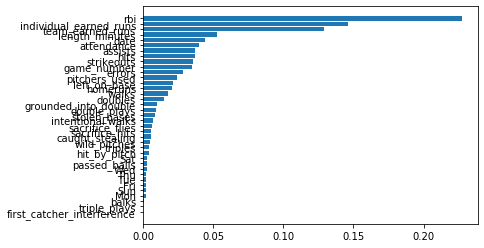

In [16]:
features = X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)),importances[indices], align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);

## XGBoost

In [33]:
# Define function to build ROC curve
def buildROC(target_train, train_preds, target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    fpr1, tpr1, threshold = metrics.roc_curve(target_train, train_preds)
    roc_auc1 = metrics.auc(fpr1, tpr1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'Train AUC = %0.2f' % roc_auc1)
    plt.plot(fpr, tpr, 'b', label = 'Validation AUC = %0.2f' % roc_auc, color = 'g')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

### Baseline XGBoost Model

For the XGBoost Model, we begin by creating a baseline model with the default parameter setting and we will try to improve the result by optimizing its hyperparameter using GridSearchCV.

In [34]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [35]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 74.68%
Validation ROC_AUC: 66.06%


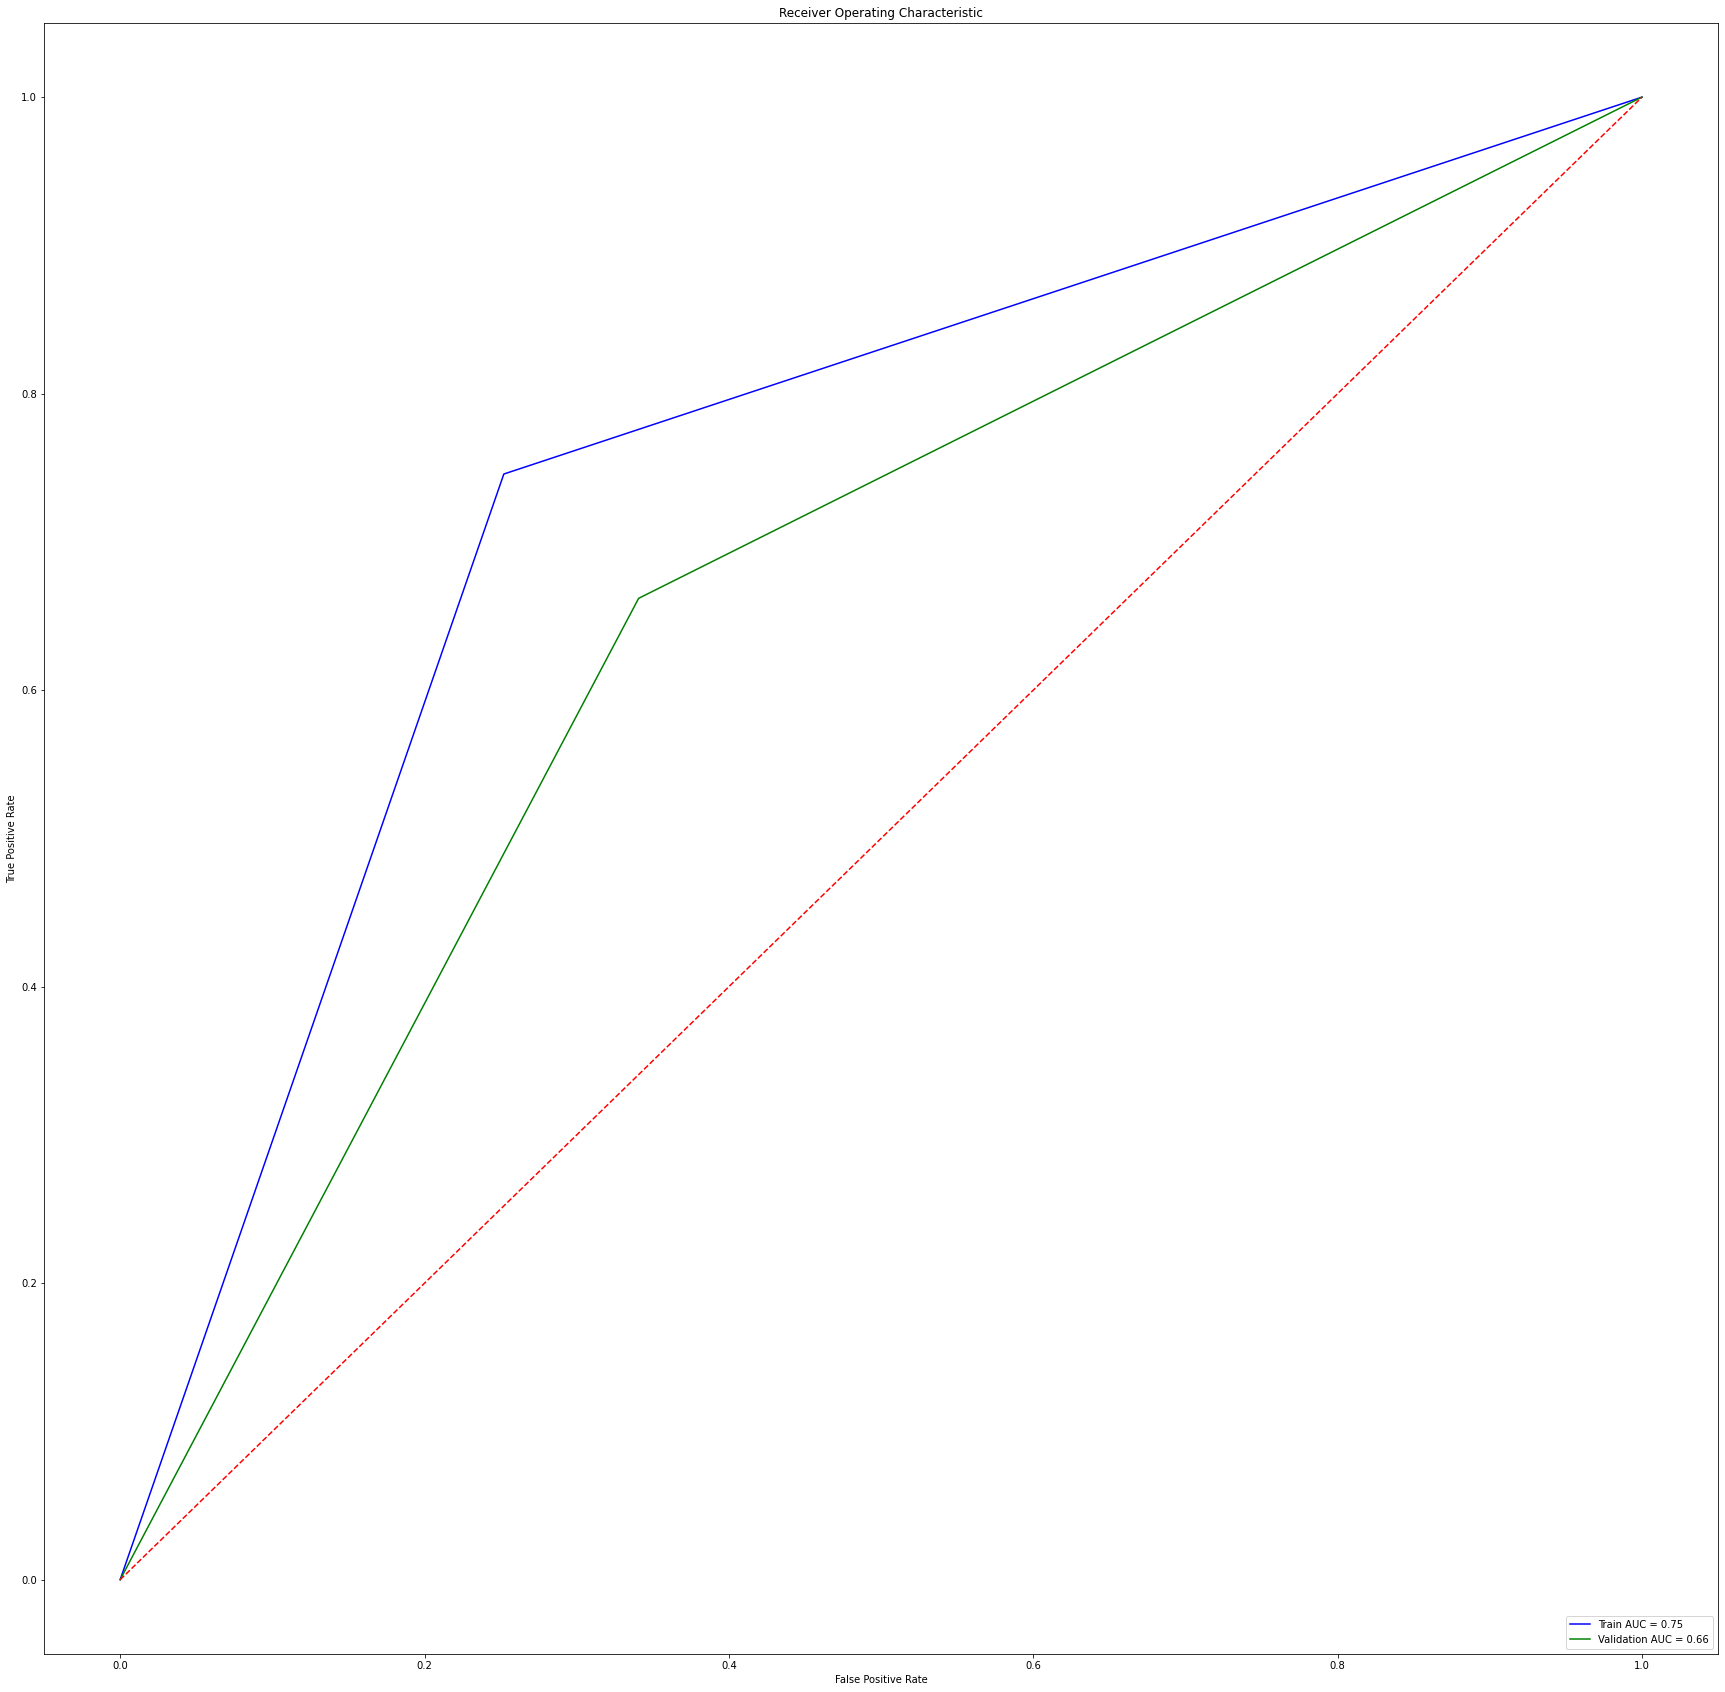

In [36]:
buildROC(y_train, training_preds, y_validate, validate_preds)

Without any hyperparameter tuning, we managed to get an improved model compared to the logistic regression model, but let's see what we can improve on when we alter the parameter grid !

### Set Initial Values for Hyperparameter Tuning 

In [37]:
# param_grid = {
#     'learning_rate': [0.05, 0.1, 0.25, 0.5],
#     'max_depth': [5, 8, 10, 13],
#     'min_child_weight': [0.1, 0.5, 1.0],
#     'subsample': [1.0],
#     'n_estimators': [100],
# }

In [38]:
# Define parameters
# param_grid = {
#     'learning_rate': [0.25],
#     'max_depth': [8],
#     'min_child_weight': [0.1],
#     'subsample': [1.0],
#     'n_estimators': [100]
# }

In [39]:
# grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
# grid_clf.fit(X_train, y_train)

# best_parameters = grid_clf.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds = grid_clf.predict(X_train)
# validate_preds = grid_clf.predict(X_validate)

# training_roc_auc = roc_auc_score(y_train, training_preds)
# validate_roc_auc = roc_auc_score(y_validate, validate_preds)

# print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
# print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Here, we see training score increased substantially but validation score only improved marginally. Hence, we try to create a more robust model by improving the validation score while trying to reduce overfitting to the training dataset.

In [40]:
# param_grid = {
#     'learning_rate': [0.25, 0.3],
#     'max_depth': [7, 8, 9],
#     'min_child_weight': [0.05, 0.1, 0.2],
#     'subsample': [1.0],
#     'n_estimators': [100],
#     'colsample_bytree': [0.3, 0.5, 0.8],     # Avoid some columns take too much credit for the prediction
#     'gamma': [1, 5, 10],                     # Regularization
# }

In [41]:
# Define parameters
# param_grid = {
#     'learning_rate': [0.25],
#     'max_depth': [9],
#     'min_child_weight': [0.05],
#     'subsample': [1.0],
#     'n_estimators': [100],
#     'colsample_bytree': [0.8],     
#     'gamma': [5],                  
# }

In [42]:
# grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
# grid_clf.fit(X_train, y_train)

# best_parameters = grid_clf.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds = grid_clf.predict(X_train)
# validate_preds = grid_clf.predict(X_validate)

# training_roc_auc = roc_auc_score(y_train, training_preds)
# validate_roc_auc = roc_auc_score(y_validate, validate_preds)

# print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
# print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

# Grid Search found the following optimal parameters: 
# colsample_bytree: 0.8
# gamma: 5
# learning_rate: 0.25
# max_depth: 9
# min_child_weight: 0.05
# n_estimators: 100
# subsample: 1.0
# Training ROC_AUC: 78.79%
# Validation ROC_AUC: 66.08%

After second round of tuning, we see slightly improved figures, with slightly higher validation score and less overfit shown by the reduction in difference between training and validation score.

In [43]:
# param_grid = {
#     'learning_rate': [0.05, 0.15, 0.25],
#     'max_depth': [9],
#     'min_child_weight': [1, 2, 4, 6, 8],
#     'subsample': [1],
#     'n_estimators': [10, 35, 50],
#     'colsample_bytree': [0.93],     
#     'gamma': [5],                   
# }

In [44]:
# param_grid = {
#     "learning_rate"    : [0.05] ,
#      "max_depth"        : [9],
#      "min_child_weight" : [6],
#     "subsample"         : [1],
#      "gamma"            : [5],
#      "colsample_bytree" : [0.93],
#      "n_estimators": [35]
# }

In [45]:
# grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
# grid_clf.fit(X_train, y_train)

# best_parameters = grid_clf.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds = grid_clf.predict(X_train)
# validate_preds = grid_clf.predict(X_validate)

# training_roc_auc = roc_auc_score(y_train, training_preds)
# validate_roc_auc = roc_auc_score(y_validate, validate_preds)

# print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
# print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

In [46]:
# buildROC(y_train, training_preds, y_validate, validate_preds)

Finally, we managed to improve the baseline XGBoost model by __2%__ with Hyperparameter Optimization, however, it is slightly more overfitted compared to the baseline model.

# Final Model Selection

After comparing the AUC scores, we have decided to select the Random Forest:

In [17]:
y_train_score = rfc.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, [y_train_score[x][1] for x in range(len(y_train_score))])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

AUC train dataset: 0.8381712842915487


In [18]:
y_validate_score = rfc.predict_proba(X_validate)
fpr, tpr, thresholds = roc_curve(y_validate, [y_validate_score[x][1] for x in range(len(y_validate_score))])
print('AUC validation dataset: {}'.format(auc(fpr, tpr)))

AUC validation dataset: 0.7233785802426951


In [19]:
y_test_score = rfc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, [y_test_score[x][1] for x in range(len(y_test_score))])
print('AUC test dataset: {}'.format(auc(fpr, tpr)))

AUC test dataset: 0.7234110159668368


### Confusion matrix and Zweig&Campbell function

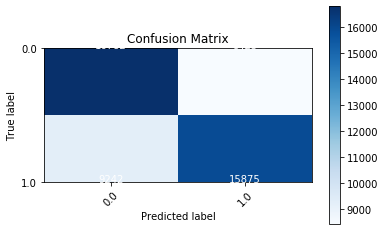

In [20]:
y_hat_test = rfc.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_hat_test)

# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

In [21]:
cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
def conf_matrix(self,y_test, y_hat_test):
        for ind, label in enumerate(y_test):
            pred = y_hat_test[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
            self.cm_values = cm
        return cm

In [22]:
conf_matrix(rfc,y_test,y_hat_test)

{'TP': 15875, 'TN': 16782, 'FP': 8425, 'FN': 9242}

Because there is only so much time for team/players training and because there is a trade-off between the time spent improving skills and avoiding spending time on a specific skill (if you are specifically working on a skill that doesn't improve the game you are wasting your time, however if you are purposefully avoiding to train a skill, you free some time to work on a different aspect, which can be relevant to your game performance), we have defined the costs of the different model outcome as follow:

In [94]:
# Focusing on a stat that improves your game
cTP = 100
# Not focusing on a stat that doesn't improve your game
cTN = 1
# Focusing on a stat that doesn't improve your game
cFP = 100
# Not focusing on a stat that improves your game
cFN = 20

prevalence = (cm['TP']+cm['FN']) / (cm['TP']+cm['FP']+cm['TN']+cm['FN'])

# Metz coefficient
_m = ((1-prevalence)/prevalence) * ((cFP-cTN) / (cFN-cTP))

# Using the Zweig & Campbell equation:
function_m = cm['TP'] -_m*cm['FP']
function_m

25536.73239240355

### Plotting the ROC curve for the Random Forest model (train, validation and test datasets)

In [87]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %75 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

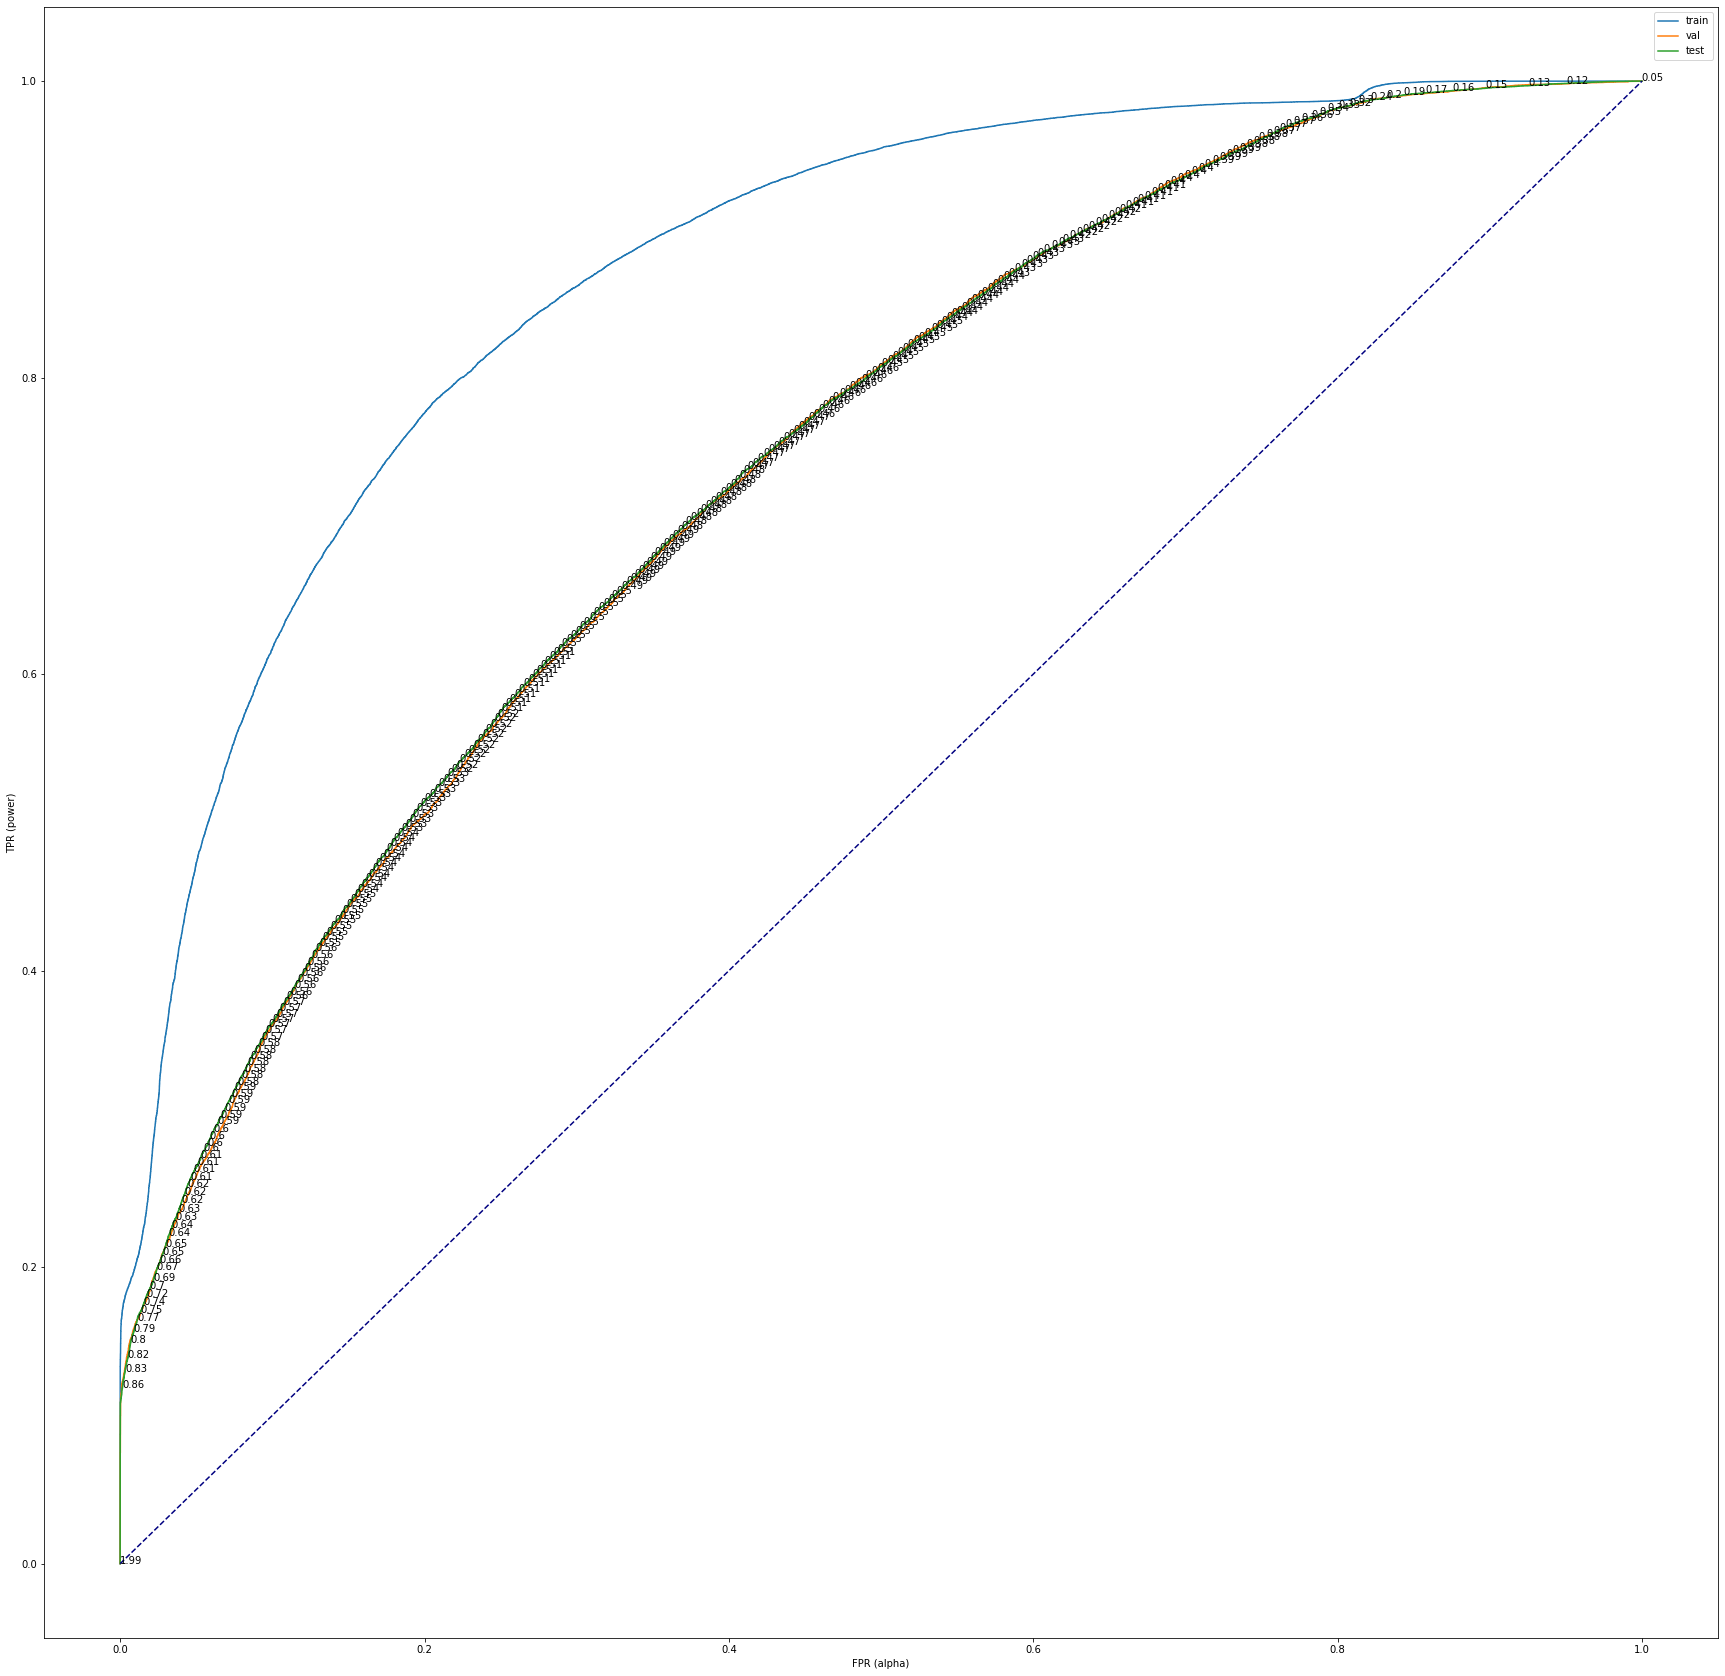

In [83]:
for data in [[y_train, y_train_score[:,1]],[y_validate, y_validate_score[:,1]],[y_test, y_test_score[:,1]]]:
    fpr, tpr, threshold = roc_curve(data[0], data[1])
    plt.plot(fpr, tpr)
annot(fpr, tpr, threshold)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('TPR (power)')
plt.xlabel('FPR (alpha)')
plt.legend(['train','validation','test'])
plt.show()

In [28]:
threshold_chosen = 0
difference = 0
for i in range(len(thresholds)):
    temp = tpr[i]-fpr[i]
    if temp>difference:
        difference=temp
        threshold_chosen=thresholds[i]
threshold_chosen = round(threshold_chosen,2)
print('Best Threshold: ',threshold_chosen)

Best Threshold:  0.5
